## making ancillary data for 

In [12]:
import numpy as np
from cmocean import cm
import matplotlib.pyplot as plt
import xarray as xr
import sys

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import sys


import gsw
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [ ]:
makeNativeVol = False #calculate native grid volumes
copyAncMask = False #copy regridded mask

## variables area, volume, mask_sfc, mask_vol are found in ancillary data, unchanged from 2022, so we can use that mask:

In [13]:
if copyAncMask:
    tdat2 = xr.open_dataset('/gpfs/data/greenocean/GCB/GCB_RECCAP/MakeAncillary/AncillaryData_v3.nc')
    tdat2.to_netcdf('/gpfs/data/greenocean/GCB/GCB2023/submissionData2023/CAL12/Tier1/AncillaryData_mask.nc')

In [55]:
if makeNativeVol:

    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    csize_broad = np.zeros([31,149,182])
    for i in range(0,31):
        csize_broad[i,:,:] = tmesh['csize'].values
    cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]


    region_mask_south = np.zeros_like(tmesh.nav_lat)
    region_mask_south[tmesh.nav_lat.values <= -30] = 1

    region_mask_tropics = np.zeros_like(tmesh.nav_lat)
    region_mask_tropics[(tmesh.nav_lat.values >= -30) & (tmesh.nav_lat.values <= 30)  ] = 1

    region_mask_north = np.zeros_like(tmesh.nav_lat)
    region_mask_north[tmesh.nav_lat.values >= 30] = 1

    Area_tot_native = np.zeros(4)
    Area_tot_native[0] = np.nansum(tmesh.csize)
    Area_tot_native[1] = np.nansum(tmesh.csize * region_mask_south)
    Area_tot_native[2] = np.nansum(tmesh.csize * region_mask_tropics)
    Area_tot_native[3] = np.nansum(tmesh.csize * region_mask_north)

    print(Area_tot_native)
    print(np.nansum(Area_tot_native[0]))
    print(np.nansum(Area_tot_native[1:4]))

    Vol_tot_native = np.nansum(cvol)
    print(f'volume in m3 {Vol_tot_native}')
    print(f'volume in km3 {Vol_tot_native *1e-9}')
    print(f'volume in billion km3 {Vol_tot_native *1e-9 * (1/1000000000) }')

    savenam = '/gpfs/data/greenocean/GCB/GCB2023/submissionData2023/CAL12/Tier1/nativeGridDimensions.nc'
    data_vars = {'Area_tot_native':(['REGION'], Area_tot_native,
    {'units': 'm2',
    'long_name':'regional surface ocean area on PlankTOM grid, 0 = globe, 1 = southern, 2 = tropics, 3 = northern'}),
                 'Vol_tot_native':(['GLOBE'], np.array([Vol_tot_native]),
    {'units': 'm3',
    'long_name':'global ocean volume on PlankTOM grid'}),
    }
    # define coordinates
    coords = {'REGION': (['REGION'], np.arange(0,4,1)),
            'GLOBE': (['GLOBE'], np.zeros(1)),
             }
    # define global attributes
    attrs = {'made in':'/gpfs/data/greenocean/GCB/GCB2023/scripts/makeAncillary.ipynb',
    'desc': 'yearly medusa files, saving only variables of interest'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)

[3.60890793e+14 1.10508668e+14 1.87700899e+14 6.26812254e+13]
360890792804973.06
360890792804973.06
volume in m3 1.339624355371383e+18
volume in km3 1339624355.3713832
volume in billion km3 1.3396243553713834


## plot atm co2 file used in model

In [79]:
import pandas as pd
w = pd.read_csv('//gpfs/data/greenocean/GCB/GCB2023/submissionData2023/CAL12/Tier1/gcbco2_2023_4200_v2_padding.dat', sep='\t')

orig = pd.read_csv('/gpfs/home/mep22dku/scratch/GCB2023_atmco2/global_co2_merged_reformat.dat', sep=',')


(270.0, 450.0)

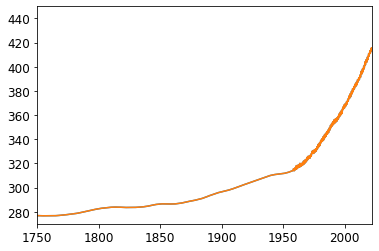

In [78]:
plt.plot(w['1650.042'],w['276.58'], label = 'used in model')
plt.plot(orig['1700.042'],orig['276.58'], label = 'from protocol')
plt.xlim([1750,2022])
plt.ylim([270,450])

## river and dust

In [81]:
dust = xr.open_dataset('/gpfs/data/greenocean/software/resources/ModelResources/Dust/dust.Jickells2005.times035.ORCA.nc', decode_times=False)

In [96]:
river = xr.open_dataset('/gpfs/data/greenocean/software/resources/ModelResources/River/river.nc', decode_times=False)
river['RIVERDIC']
print(np.nansum(river.RIVERDIC.values))
print(np.nansum(river.RIVERDOC.values))
print(np.nansum(river.RIVERPOC.values))
riverinputs = (np.nansum(river.RIVERDIC.values + river.RIVERDOC.values + river.RIVERPOC.values) * 1/1000)
riverinputs

385.5548
189.42738
147.88115


0.7228634033203125

In [99]:
savenam = '/gpfs/data/greenocean/GCB/GCB2023/submissionData2023/CAL12/Tier1/RiverAndBurial.nc'
data_vars = {'RivCin':(['GLOBE'], np.array([riverinputs]),
{'units': 'PgC/yr',
'long_name':'River carbon inflow into the ocean, time-average'}),
'Burial':(['GLOBE'], np.array([riverinputs]),
{'units': 'PgC/yr',
'long_name':'Net C flux into the sediment, timeaverage'}),

}
# define coordinates
coords = {
        'GLOBE': (['GLOBE'], np.zeros(1)),
         }
# define global attributes
attrs = {'made in':'/gpfs/data/greenocean/GCB/GCB2023/scripts/makeAncillary.ipynb',
'desc': ''
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)
ds.to_netcdf(savenam)